# 시계열 데이터 분석

## 1.환경준비

### (1) 라이브러리

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### (2) 데이터

* KOSPI 지수 데이터

In [5]:
kospi = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/KOSPI.csv"
                   , usecols= ['Date', 'Close', 'Volume'])

kospi['Date'] = pd.to_datetime(kospi['Date'])
kospi['Year'] = kospi['Date'].dt.year
kospi['Month'] = kospi['Date'].dt.month
kospi['Weekday'] = kospi['Date'].dt.weekday

kospi['Close_Lag'] = kospi['Close'].shift()
kospi['Volume_Lag'] = kospi['Volume'].shift()
kospi.drop('Volume', axis = 1, inplace = True)
kospi.dropna(axis=0, inplace=True)

kospi.head()

,Date,Close,Year,Month,Weekday,Close_Lag,Volume_Lag
1,2014-10-01,1991.54,2014,10,2,2020.09,322812.0
2,2014-10-02,1976.16,2014,10,3,1991.54,351581.0
3,2014-10-06,1968.39,2014,10,0,1976.16,322656.0
4,2014-10-07,1972.91,2014,10,1,1968.39,325078.0
5,2014-10-08,1965.25,2014,10,2,1972.91,328234.0


* 서울시 공유자전거

In [7]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBike_Simple.csv'
bike = pd.read_csv(path)
bike['Datetime'] = pd.to_datetime(bike['Datetime'] )
bike.rename(columns={'Rented Bike Count':'Count'}, inplace = True)
bike = bike.loc[bike['Datetime'].between('2018-06-11','2018-08-13', inclusive = 'left'),
                      ['Datetime', 'Temperature', 'Humidity','Count']]
bike.reset_index(drop = True, inplace = True)

* 유통점 판매데이터

In [9]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
retail = pd.read_csv(path)
retail['date'] = pd.to_datetime(retail['date'])
# retail = retail.loc[retail['date'].between('2013-06-01', '2015-10-31')].reset_index(drop = True)
retail

,date,item,sales,tot_sales,comp_sales
0,2013-01-01,28,45,456,43
1,2013-01-02,28,53,474,57
2,2013-01-03,28,65,519,45
3,2013-01-04,28,66,527,45
4,2013-01-05,28,97,575,55
...,...,...,...,...,...
1821,2017-12-27,28,82,680,79
1822,2017-12-28,28,114,743,68
1823,2017-12-29,28,101,776,67
1824,2017-12-30,28,120,901,79


## 2.시계열 데이터란?

* 데이터셋
    * 일반 데이터셋 : 분석단위(행) 하나 하나가 개별 instance 입니다.
    * 시계열 데이터 : 데이터 분석 단위(행) 간에 (시간) 순서(sequence)가 있는 데이터

* 시계열 데이터 구분은, 비즈니스 이해단계에서 [문제정의]시 결정 됩니다.
    * 해결해야 할 문제가 시간 순서 관점이 필요한지 아닌지.


* KOSPI 2014.10 ~ 2019.09 데이터
    * Close : 코스피 종가(target)
    * Weekday : 요일 (0-월요일, 6-일요일)
    * Close_Lag : 전날 종가
    * Volume_Lag : 전날 거래량

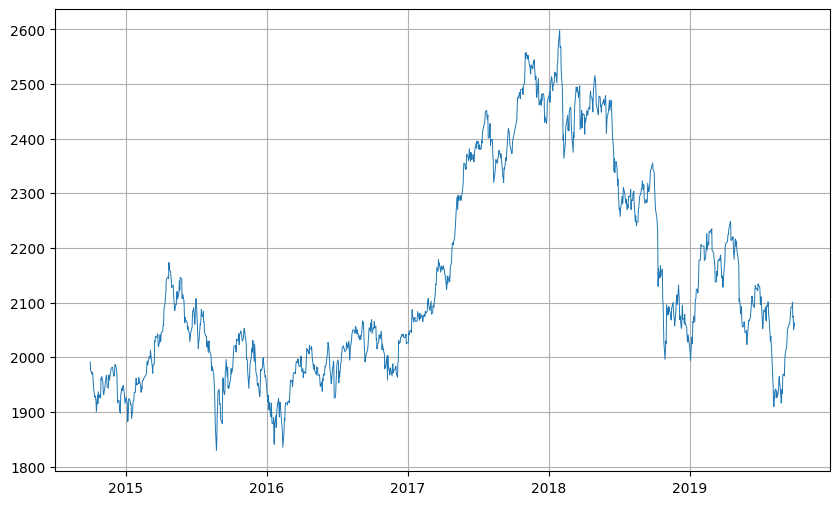

In [11]:
plt.figure(figsize = (10,6))
plt.plot('Date', 'Close', data = kospi, linewidth = .7)
plt.grid()
plt.show()

* 시계열 데이터는 시간(시기)을 고려해야 합니다.
    * 어느 기간?
    * 반복되는 주기?


## 3.기존 분석 방식 적용시 문제점

### (1) 단변량분석

#### 1) 숫자

* Close의 분포를 살펴보면…
    * 하나의 박스플롯으로 설명이 되나요?
    * 히스트그램을 보면 분포가 여러 개로 나뉘어 보입니다. 어떻게 해석해야 할까요?



In [ ]:
sns.histplot(x = 'Close', data = kospi, bins = 50)
plt.show()

In [ ]:
sns.boxplot(x = 'Close', data = kospi)
plt.show()

#### 2) 범주

In [ ]:
sns.countplot(x="Weekday", data = kospi)
plt.show()

In [ ]:
temp = kospi['Weekday'].value_counts()

plt.pie(temp.values, labels = temp.index, autopct='%.2f%%')
plt.show()

### (2) 이변량

#### 1) 숫자 vs 숫자

* 전날 종가와 오늘 종가를 비교해 보겠습니다.
    * 산점도 : 완전 직선
    * 상관분석 : 상관계수 거의 1, p-value 는 0!
    * 그러면 전날 종가만 있으면 다음날 코스피 지수 예측은 확실한가요?

In [ ]:
sns.regplot(x = 'Close_Lag', y = 'Close', data = kospi,  line_kws={'color': 'darkred'})
plt.show()

In [ ]:
# 상관계수와 p-value
spst.pearsonr(kospi['Close_Lag'], kospi['Close'])

#### 2) 범주 vs 숫자

* 요일별로 주가가 달라질까요?
    * 요일은 주가와 아무런 관련이 없어 보입니다.
    * 진짜 그럴까요?

In [ ]:
temp = kospi.loc[kospi.Date.between('2019-01-01','2019-01-31')]

sns.barplot(x="Weekday", y="Close", data = temp)
plt.grid()
plt.show()

## 4.시계열 데이터 분석 방법

### (1) 시간의 흐름에 따른 패턴 찾기

#### 1) 시간의 흐름에 따른 추세 분석 : 라인차트

* KOSPI 지수 라인차트 그리기

In [ ]:
plt.figure(figsize = (12,4))
sns.lineplot(x = 'Date', y = 'Close', data = kospi, linewidth = .7)
plt.show()

* 지수와 거래량을 한꺼번에 라인차트로 그리기

In [ ]:
# 거래량 추가
plt.figure(figsize = (12,5))
sns.lineplot(x = 'Date', y = 'Close', data = kospi, label = 'Close', color = 'blue', linewidth = .7)
sns.lineplot(x = 'Date', y = 'Volume_Lag', data = kospi, label = 'Volume', color = 'green', linewidth = .5)
plt.show()

In [ ]:
# 축을 양쪽에 두고 그립시다.
plt.figure(figsize = (12,5))
# 왼쪽 축
ax1 = sns.lineplot(x = 'Date', y = 'Close', data = kospi, label = 'Close', color = 'blue', linewidth = .5)
plt.legend(loc='upper left')

 # 오른쪽 축 생성
ax2 = ax1.twinx()
sns.lineplot(x = 'Date', y = 'Volume_Lag', data = kospi, label = 'Volume', color = 'green', linewidth = .5)
plt.legend(loc='upper right')

# 그래프 출력
plt.show()

<img src='https://raw.githubusercontent.com/jangrae/img/master/practice_01.png' width=120 align="left"/>

[문1] bike의 수요량(Count) 그래프를 그려봅시다.  
> * 처음부터 400개 데이터만 뽑아서 라인차트를 그립니다.
> * 그래프를 관찰하고 패턴을 찾아 적어 봅시다.


[문2] bike의 대여량(Count)과 온도(Temperature) 그래프를 그려봅시다.  
> * 처음부터 400개 데이터만 뽑아서 라인차트를 그립니다.
> * 그래프를 관찰하고 패턴을 찾아 적어 봅시다.


#### 2) 시계열 데이터 분해(Decomposition)
* 시계열 데이터 안에 있는 반복 추세와 반복 패턴을 찾아내는 과정입니다.
* 찾아낸 패턴을 하나의 모델로 볼 수도 있습니다.

① 시계열 데이터 분해 결과 시각화 함수


In [ ]:
def decomp_plot(decomp) :
    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

① 시계열 데이터를 분해해 봅시다.
* freq 를 조절하며 계절성(seasonal)을 도출해 봅시다.
* 그래프는 위에서 만든 decomp_plot 을 사용합니다.

* 1일(24시간)의 계절성 고려

In [ ]:
# 시계열 데이터 분해
decomp = sm.tsa.seasonal_decompose(bike['Count'], model = 'additive', period = 24)

# 그래프 그리기
plt.figure(figsize=(12, 8))
result = decomp_plot(decomp)

* 1주일(7일 * 24시간)의 계절성 고려

In [ ]:
# 시계열 데이터 분해
decomp = sm.tsa.seasonal_decompose(bike['Count'], model = 'additive', period = 24 * 7)

# 그래프 그리기
plt.figure(figsize=(12, 8))
result = decomp_plot(decomp)

<img src='https://raw.githubusercontent.com/jangrae/img/master/practice_01.png' width=120 align="left"/>

[문1] retail의 판매량(sales)에 대한 시계열 데이터 분해를 수행해 봅시다.  
* 먼저 라인차트를 그려서 주기, 패턴을 찾습니다.
    * 전체 데이터에 대해 라인차트 그리기
    * 데이터의 일부(약 1 ~ 2개월)에 대해 라인차트 그리기


[문1] retail의 판매량(sales)에 대한 시계열 데이터 분해를 수행해 봅시다.  
* 찾은 패턴을 기반으로 시계열 데이터를 분해 하고 그래프로 그려봅니다.
    * 주기 7과 365, 두 가지를 기준으로 각각 분해해 봅시다.


#### 3) [참조]자기상관함수(ACF)

In [ ]:
plot_acf(bike['Count'], lags = 60)
plt.grid()
plt.show()

In [ ]:
# 반복문으로 시차를 늘려가면서 데이터셋 만들기
temp = bike[['Count']].copy()

for i in range(1,21) :
    var = 'lag' + str(i)
    temp[var] = temp['Count'].shift(i)

In [ ]:
temp.head(20)

In [ ]:
# 각 시차간의 상관계수
temp.corr()

In [ ]:
plot_acf(bike['Count'], lags = 60)
plt.grid()
plt.show()

### (2) 패턴을 데이터로 만들기

#### 1) 날짜 요소 추출

| 메서드 | 내용|
|----|----|
df['date'].dt.date         		| YYYY-MM-DD(문자)
df['date'].dt.year         		| 연(4자리숫자)
df['date'].dt.month        		| 월(숫자)
df['date'].dt.month_name()		| 월(문자)
df['date'].dt.day          		| 일(숫자)
df['date'].dt.time         		| HH:MM:SS(문자)
df['date'].dt.hour         		| 시(숫자)
df['date'].dt.minute       		| 분(숫자)
df['date'].dt.second       		| 초(숫자)
df['date'].dt.quarter       		| 분기(숫자)
df['date'].dt.day_name()  	| 요일이름(문자)
df['date'].dt.weekday       		| 요일숫자(0-월, 1-화) (=dayofweek)
df['date'].dt.weekofyear    		| 연 기준 몇주째(숫자) (=week)
df['date'].dt.dayofyear     		| 연 기준 몇일째(숫자)
df['date'].dt.days_in_month 	| 월 일수(숫자) (=daysinmonth)



In [ ]:
temp = bike.copy()

① 요일

In [ ]:
temp['Datetime'].dt.weekday

In [ ]:
temp['weekday'] = temp['Datetime'].dt.weekday
temp.head()

② 시간대

In [ ]:
temp['hour'] = temp['Datetime'].dt.hour
temp.head()

<img src='https://raw.githubusercontent.com/jangrae/img/master/practice_01.png' width=120 align="left"/>

[문1] 위에서 생성한 temp에 다음의 변수를 추가해 봅시다.

* 주말여부
* 주요 시간대 범주화
    * 범주 종류 : 0 - 활동 없음, 1 - 일상 활동시간, 2 - 출퇴근
    * 시간대
        * 0~6 : 0
        * 7~8 : 2
        * 9~16: 1
        * 17~20 : 2
        * 21~23 : 0

#### 2) 시간의 흐름을 feature로 담기

① shift

In [ ]:
temp2 = bike[['Datetime', 'Count']].copy()
temp2.head()

In [ ]:
# shift(1)
temp2['lag1'] = temp2['Count'].shift()

# shift(2)
temp2['lag2'] = temp2['Count'].shift(2)

# shift(-1)
temp2['lag_1'] = temp2['Count'].shift(-1)
temp2.head()

② rolling

In [ ]:
temp2 = bike[['Datetime', 'Count']].copy()
temp2.head()

In [ ]:
# 3일 이동평균
temp2['MA3'] = temp2['Count'].rolling(3).mean()

# 3일 이동최대값
temp2['MM3'] = temp2['Count'].rolling(3).max()

# 3일 이동평균(min_period = 1)
temp2['MA3_1'] = temp2['Count'].rolling(3, min_periods=1).mean()

temp2.head()

③ diff : 특정 시점 대비 증감

In [ ]:
temp2 = bike[['Datetime', 'Count']].copy()
temp2.head()

In [ ]:
# 전시점대비 증감
temp2['Diff1'] = temp2['Count'].diff()

# 전전시점 대비 증가
temp2['Diff2'] = temp2['Count'].diff(2)

temp2.head()

<img src='https://raw.githubusercontent.com/jangrae/img/master/practice_01.png' width=120 align="left"/>

[문1] temp에 24시간 전 대여량을 추가하시오.

[문2] temp에 4시간 이동평균 대여량을 추가하시오.

[문3] temp에 24시간 전 대비 대여량 증감을 추가하시오.

### (3) 어떤 패턴도 보이지 않는 y
* 이전 데이터 대비 증감으로 분석하기

In [ ]:
# 데이터 차분(difference) 데이터를 만들고
kospi['diff'] = kospi['Close'].diff()

In [ ]:
# 그래프를 그리면, 이전과 다른 새로운 관점의 그래프를 얻을 수 있습니다.

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.histplot(x = 'Close', data = kospi, bins = 50)

plt.subplot(1,2,2)
sns.histplot(x = 'diff', data = kospi, bins = 50)
plt.show()